# 2nd-order elastic with a diagonal boundary

This notebook considers an even more fancy boundary.

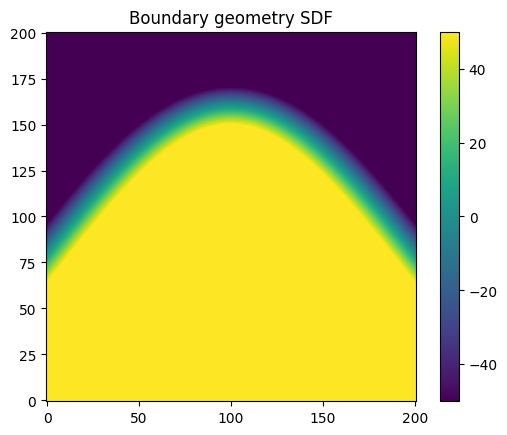

In [1]:
# Load the signed distance function for the boundary geometry
import pickle
import matplotlib.pyplot as plt
import numpy as np

def read_sdf(surface, dims):
    """Unpickle an sdf"""
    fname = '../tests/sdfs/' + surface + '_' + str(dims) + 'd.dat'
    with open(fname, 'rb') as f:
        sdf = pickle.load(f)
    return sdf

# Load the sinusoid 2D sdf
sdf = read_sdf('sinusoid_new_hi_res', 2)

plt.imshow(sdf.data.T, origin='lower')
plt.title("Boundary geometry SDF")
plt.colorbar()
plt.show()

In [2]:
import sympy as sp
from schism import BoundaryGeometry
zero = sp.core.numbers.Zero()

cutoff = {(zero, zero): 0.}
bg = BoundaryGeometry(sdf, cutoff)
grid = bg.grid  # Gets the grid from the signed distance function

Operator `normals` ran in 0.01 s


In [3]:
import devito as dv
import numpy as np
import matplotlib.pyplot as plt

s_o = 4

ux = dv.TimeFunction(name='ux', grid=grid, space_order=s_o, time_order=2)
uy = dv.TimeFunction(name='uy', grid=grid, space_order=s_o, time_order=2)

# Material parameters
rho = 1.
v_p = 1.
v_s = 0.4  # 0.65
mu = rho*v_s**2  # 0.25
lam = rho*v_p**2 - 2*mu  # 0.5

# Shorthand
b = 1./rho

In [4]:
from schism import BoundaryConditions

nx = bg.n[0]
ny = bg.n[1]

# With fourth-order boundary conditions
bc_list = [dv.Eq(nx*(lam+2*mu)*ux.dx + nx*lam*uy.dy
                 + ny*mu*ux.dy + ny*mu*uy.dx, 0),
           dv.Eq(nx*mu*ux.dy + nx*mu*uy.dx
                 + ny*(lam+2*mu)*uy.dy + ny*lam*ux.dx, 0),
           dv.Eq(lam*mu*nx*uy.dy3 + mu**2*ny*ux.dy3
                 + ux.dx2dy*ny*(lam**2 + 2*lam*mu + 2*mu**2)
                 + ux.dx3*nx*(lam**2 + 4*lam*mu + 4*mu**2)
                 + ux.dxdy2*nx*(2*lam*mu + 3*mu**2)
                 + uy.dx2dy*nx*(lam**2 + 3*lam*mu + mu**2)
                 + uy.dx3*ny*(lam*mu + 2*mu**2)
                 + uy.dxdy2*ny*(lam**2 + 3*lam*mu + 3*mu**2), 0),
           dv.Eq(lam*mu*ny*ux.dx3 + mu**2*nx*uy.dx3
                 + ux.dx2dy*nx*(lam**2 + 3*lam*mu + 3*mu**2)
                 + ux.dxdy2*ny*(lam**2 + 3*lam*mu + mu**2)
                 + ux.dy3*nx*(lam*mu + 2*mu**2)
                 + uy.dx2dy*ny*(2*lam*mu + 3*mu**2)
                 + uy.dxdy2*nx*(lam**2 + 2*lam*mu + 2*mu**2)
                 + uy.dy3*ny*(lam**2 + 4*lam*mu + 4*mu**2), 0)]

bcs = BoundaryConditions(bc_list)

In [5]:
from schism import Boundary

boundary = Boundary(bcs, bg)

derivs = (ux.dx2, ux.dy2, ux.dxdy, uy.dx2, uy.dy2, uy.dxdy)

subs = boundary.substitutions(derivs)

Generating stencils for Derivative(ux(t, x, y), (x, 2))


Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s


Generating stencils for Derivative(ux(t, x, y), (y, 2))


Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s


Generating stencils for Derivative(ux(t, x, y), x, y)


Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s


Generating stencils for Derivative(uy(t, x, y), (x, 2))


Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s


Generating stencils for Derivative(uy(t, x, y), (y, 2))


Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s


Generating stencils for Derivative(uy(t, x, y), x, y)


Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s
Operator `eval_coeffs` ran in 0.01 s


In [42]:
from examples.seismic import TimeAxis, RickerSource

# Reset the fields
ux.data[:] = 0
uy.data[:] = 0

c = np.sqrt(b*(lam+2*mu))

t0 = 0.  # Simulation starts a t=0
tn = 800.  # 650.  # Simulation last 0.85 seconds (850 ms)
dt = 0.5*grid.spacing[0]/c  # Time step from grid spacing

time_range = TimeAxis(start=t0, stop=tn, step=dt)

f0 = 0.006  # 0.008  # Source peak frequency is 8Hz (0.008 kHz)
src = RickerSource(name='src', grid=grid, f0=f0,
                   npoint=1, time_range=time_range)

src.coordinates.data[0, 0] = 500.
src.coordinates.data[0, 1] = 650.

In [43]:
# Stability check
alpha = np.sqrt((lam+2*mu)/rho)
beta = np.sqrt(mu/rho)
dx = np.amin(grid.spacing)


print(dt)
print("Must be smaller than")
print(dx/np.sqrt(alpha**2 + beta**2))

2.5
Must be smaller than
4.642383454426296


In [44]:
rhs_ux = b*(lam+2*mu)*ux.dx2 + b*mu*ux.dy2 + b*(lam+mu)*uy.dxdy
rhs_uy = b*(lam+2*mu)*uy.dy2 + b*mu*uy.dx2 + b*(lam+mu)*ux.dxdy

eq_ux = dv.Eq(ux.forward,
              2*ux - ux.backward
              + dt**2*rhs_ux.subs(subs))

eq_uy = dv.Eq(uy.forward,
              2*uy - uy.backward
              + dt**2*rhs_uy.subs(subs))

In [45]:
src_ux = src.inject(field=ux.forward, expr=src*dt**2)
src_uy = src.inject(field=uy.forward, expr=-src*dt**2)

In [46]:
nsnaps = 4

# Set up snapshotting
steps = src.nt
factor = int(steps/nsnaps)
t_sub = dv.ConditionalDimension('t_sub', parent=grid.time_dim,
                                factor=factor)

# Buffer size needs to be more robust
uxsave = dv.TimeFunction(name='uxsave', grid=grid, time_order=0,
                         save=nsnaps+1, time_dim=t_sub)
uysave = dv.TimeFunction(name='uysave', grid=grid, time_order=0,
                         save=nsnaps+1, time_dim=t_sub)

eq_save_ux = dv.Eq(uxsave, ux)
eq_save_uy = dv.Eq(uysave, uy)

In [47]:
op = dv.Operator([eq_ux, eq_uy,
                  eq_save_ux, eq_save_uy] + src_ux)
op(time=time_range.num-1, dt=dt)

Operator `Kernel` ran in 5.48 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=5.471771000000003, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=0.0009429999999999999, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section2', rank=None),
                     PerfEntry(time=0.0003380000000000012, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[]))])

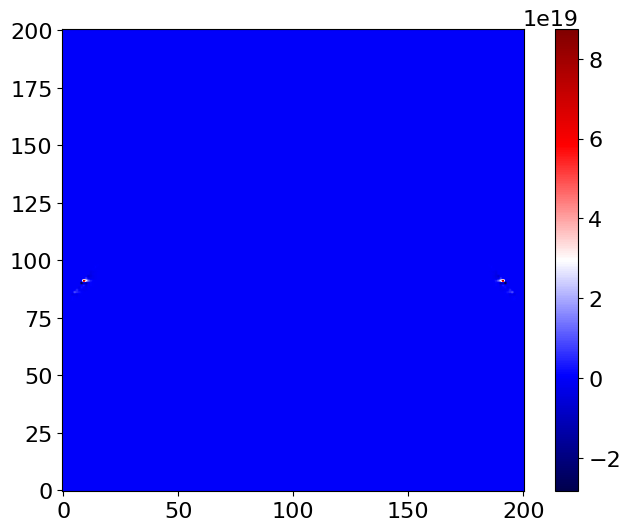

In [48]:
plt.imshow(ux.data[1].T, origin='lower', cmap='seismic')
plt.colorbar()
plt.show()

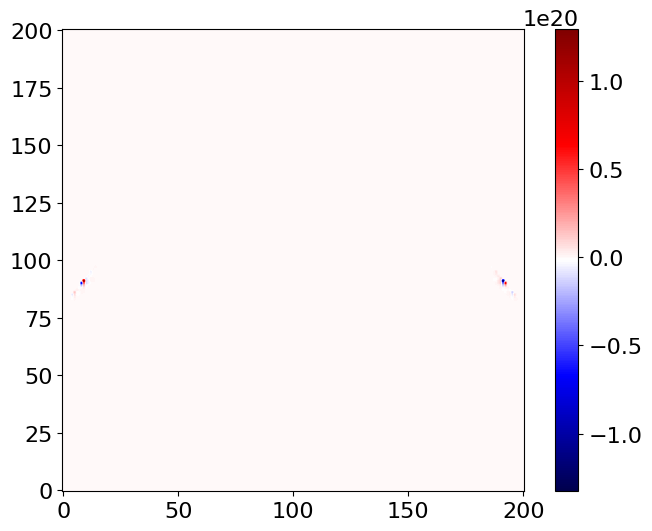

In [49]:
plt.imshow(uy.data[1].T, origin='lower', cmap='seismic')
plt.colorbar()
plt.show()

In [50]:
# Save the fields
ux_old = ux.data.copy()
uy_old = uy.data.copy()

uxsave_old = uxsave.data.copy()
uysave_old = uysave.data.copy()

# Reset the fields
ux.data[:] = 0
uy.data[:] = 0

uxsave.data[:] = 0
uysave.data[:] = 0

In [51]:
import sympy as sp

# Set up wavenumber filter
def get_filter(f, dim, hs, mask):
    """Return a set of equations to apply the filter"""
    if hs == 4:
        # 8th order
        coeffs = np.array([-1., 8., -28., 56., 186., 56., -28., 8., -1.])/256.
    elif hs == 3:
        # 6th order
        coeffs = np.array([1., -6., 15., 44., 15., -6., 1.])/64.
    elif hs == 2:
        # 4th order
        coeffs = np.array([-1., 4., 10., 4., -1.])/16.
    elif hs == 1:
        coeffs = np.array([1., 2., 1.])/4.
        
    h_dim = dim.spacing
    indices = tuple(range(-hs, 1+hs))
    points = [f.subs(dim, dim+i*h_dim) for i in indices]

    expr = sum(coeff*point for coeff, point in zip(coeffs, points))
    
    # Temporary function to store filtered values
    # NOTE: Could just have one of these and reuse it
    f_temp = dv.Function(name=f.name+'_temp_'+mask.name+'_'+dim.name, grid=f.grid, space_order=0)
    
    # Fill temp with filtered values, then set f to filtered values
    eq_filter = dv.Eq(f_temp, expr, implicit_dims=mask)
    eq_set = dv.Eq(f, f_temp, implicit_dims=mask)
    
    return [eq_filter, eq_set]

hs = 4
x, y = grid.dimensions

mask4 = dv.ConditionalDimension(name='mask4', parent=y,
                                condition=dv.Gt(sdf, 3*grid.spacing[0]))
mask3 = dv.ConditionalDimension(name='mask3', parent=y,
                                condition=sp.And(dv.Gt(sdf, 2*grid.spacing[0]),
                                                 dv.Le(sdf, 3*grid.spacing[0])))
mask2 = dv.ConditionalDimension(name='mask2', parent=y,
                                condition=sp.And(dv.Gt(sdf, grid.spacing[0]),
                                                 dv.Le(sdf, 2*grid.spacing[0])))
mask1 = dv.ConditionalDimension(name='mask1', parent=y,
                                condition=sp.And(dv.Gt(sdf, 0),
                                                 dv.Le(sdf, grid.spacing[0])))

# Filter velocity components
filter_ux_x4 = get_filter(ux.forward, x, 4, mask4)
filter_ux_y4 = get_filter(ux.forward, y, 4, mask4)
filter_uy_x4 = get_filter(uy.forward, x, 4, mask4)
filter_uy_y4 = get_filter(uy.forward, y, 4, mask4)

filter_ux_x3 = get_filter(ux.forward, x, 3, mask3)
filter_ux_y3 = get_filter(ux.forward, y, 3, mask3)
filter_uy_x3 = get_filter(uy.forward, x, 3, mask3)
filter_uy_y3 = get_filter(uy.forward, y, 3, mask3)

filter_ux_x2 = get_filter(ux.forward, x, 2, mask2)
filter_ux_y2 = get_filter(ux.forward, y, 2, mask2)
filter_uy_x2 = get_filter(uy.forward, x, 2, mask2)
filter_uy_y2 = get_filter(uy.forward, y, 2, mask2)

filter_ux_x1 = get_filter(ux.forward, x, 1, mask1)
filter_ux_y1 = get_filter(ux.forward, y, 1, mask1)
filter_uy_x1 = get_filter(uy.forward, x, 1, mask1)
filter_uy_y1 = get_filter(uy.forward, y, 1, mask1)

In [52]:
op = dv.Operator([eq_ux, eq_uy]
                 + filter_ux_x4 + filter_ux_y4
                 + filter_uy_x4 + filter_uy_y4
                 + filter_ux_x3 + filter_ux_y3
                 + filter_uy_x3 + filter_uy_y3
                 + filter_ux_x2 + filter_ux_y2
                 + filter_uy_x2 + filter_uy_y2
                 + filter_ux_x1 + filter_ux_y1
                 + filter_uy_x1 + filter_uy_y1
                 + [eq_save_ux, eq_save_uy]
                 + src_ux)
op(time=time_range.num-1, dt=dt)

Operator `Kernel` ran in 5.91 s


PerformanceSummary([(PerfKey(name='section0', rank=None),
                     PerfEntry(time=5.721071, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section1', rank=None),
                     PerfEntry(time=0.04685500000000004, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section2', rank=None),
                     PerfEntry(time=0.03262799999999997, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section3', rank=None),
                     PerfEntry(time=0.019819999999999973, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section4', rank=None),
                     PerfEntry(time=0.018168999999999977, gflopss=0.0, gpointss=0.0, oi=0.0, ops=0, itershapes=[])),
                    (PerfKey(name='section5', rank=None),
                     PerfEntry(time=0.016135000000000004, gflopss=0.0, gpointss=0

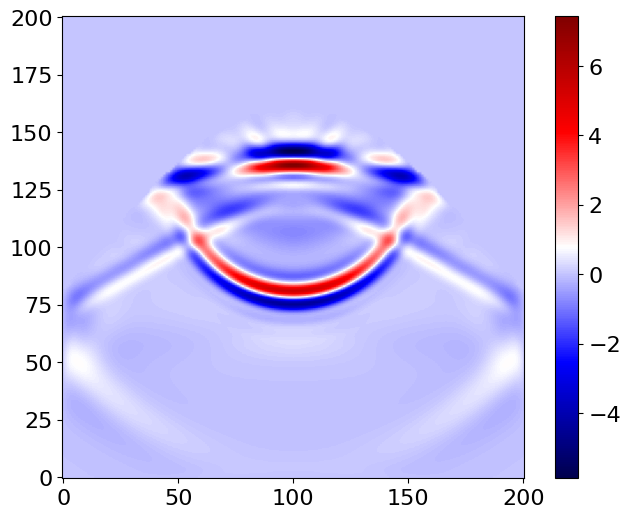

In [53]:
plt.imshow(ux.data[1].T, origin='lower', cmap='seismic')
plt.colorbar()
plt.show()

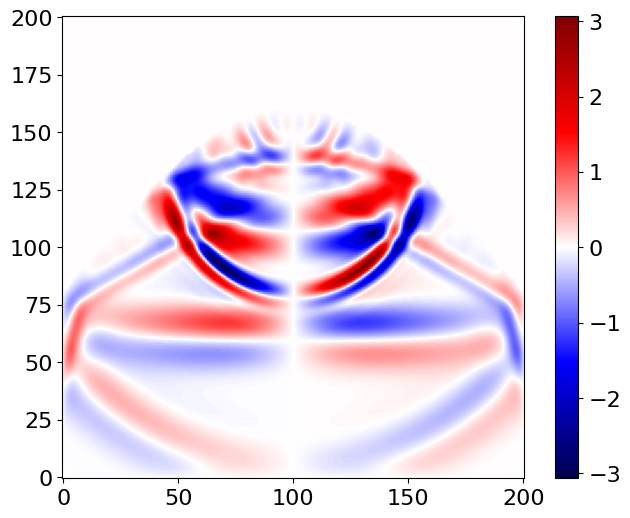

In [54]:
plt.imshow(uy.data[1].T, origin='lower', cmap='seismic')
plt.colorbar()
plt.show()

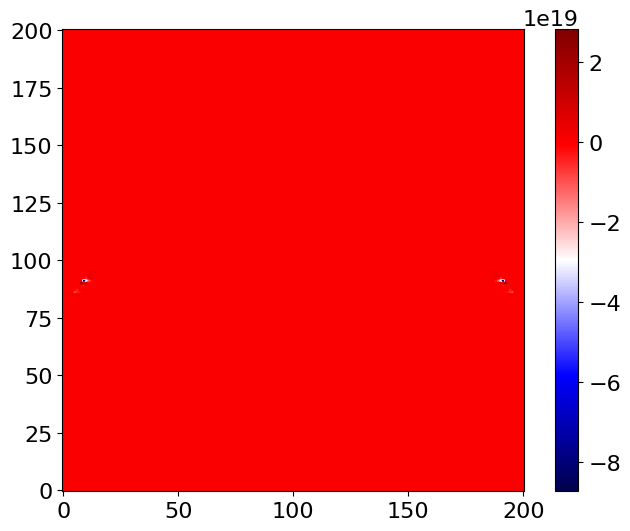

In [55]:
plt.imshow(ux.data[1].T - ux_old[1].T, origin='lower', cmap='seismic')
plt.colorbar()
plt.show()

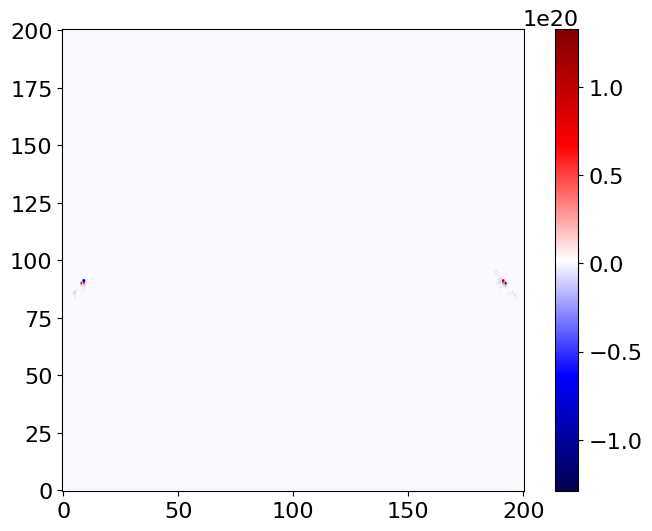

In [56]:
plt.imshow(uy.data[1].T - uy_old[1].T, origin='lower', cmap='seismic')
plt.colorbar()
plt.show()

208.88432
243.893
247.53526
246.9577


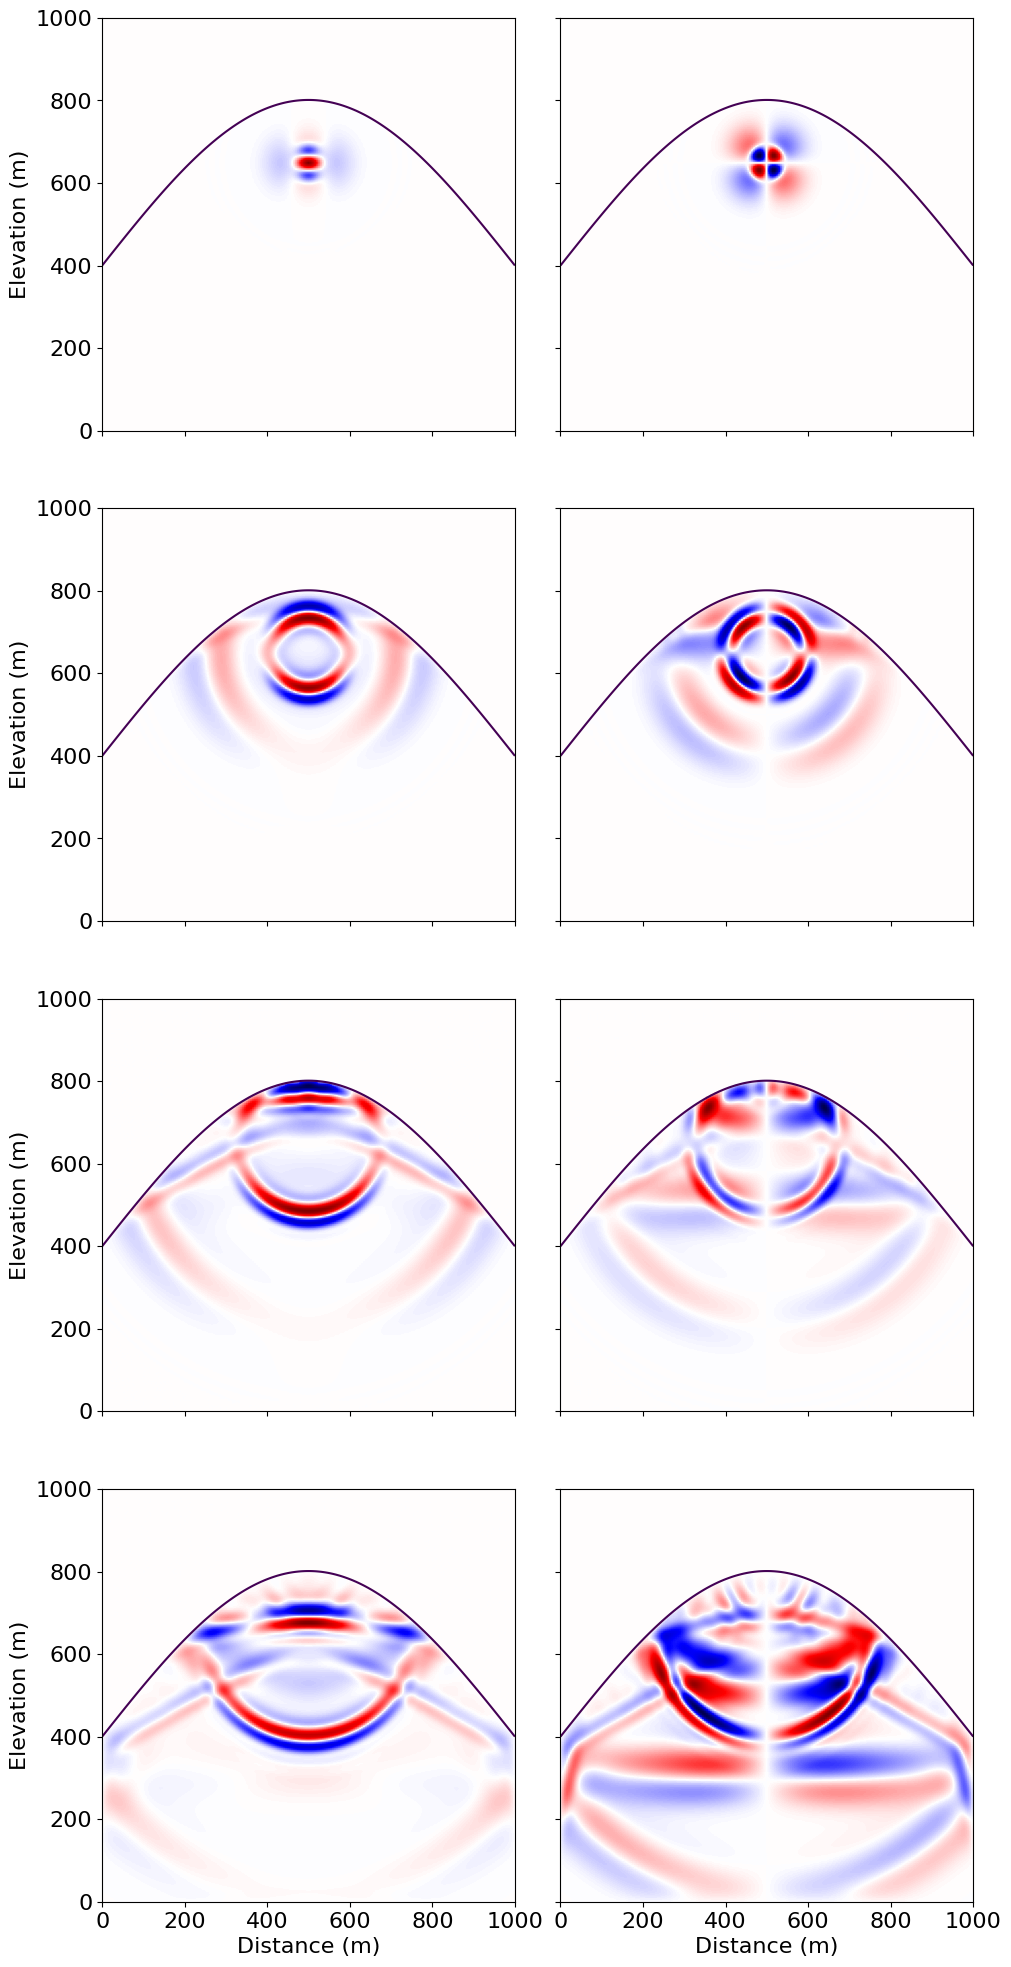

In [57]:
def plot_snaps(uxsave_data, uysave_data, sdf, file):
    for i in range(1, 5):
        print(np.linalg.norm(uxsave_data[i])
              + np.linalg.norm(uysave_data[i]))
    # Plot extent
    plt_ext = (0., 1000., 0., 1000.)

    # Plot surface with SDF contours
    xvals = np.linspace(0., 1000., uxsave_data.shape[1])
    yvals = np.linspace(0., 1000., uxsave_data.shape[2])
    xmsh, ymsh = np.meshgrid(xvals, yvals, indexing='ij')

    fig, axs = plt.subplots(4, 2, constrained_layout=True,
                            figsize=(10, 20),
                            sharex=True, sharey=True)

    for i in range(1, 5):
        vmax = np.amax(np.abs(uxsave_data[i]))
        vmin = -vmax
        axs[i-1, 0].imshow(uxsave_data[i].T, origin='lower',
                           extent=plt_ext, vmax=vmax, vmin=vmin,
                           cmap='seismic')
        axs[i-1, 0].contour(xmsh, ymsh, sdf.data, [0])
        if i == 4:
            axs[i-1, 0].set_xlabel("Distance (m)")
        axs[i-1, 0].set_ylabel("Elevation (m)")

    for i in range(1, 5):
        vmax = np.amax(np.abs(uysave_data[i]))
        vmin = -vmax
        axs[i-1, 1].imshow(uysave_data[i].T, origin='lower',
                           extent=plt_ext, vmax=vmax, vmin=vmin,
                           cmap='seismic')
        axs[i-1, 1].contour(xmsh, ymsh, sdf.data, [0])
        if i == 4:
            axs[i-1, 1].set_xlabel("Distance (m)")
    # plt.savefig(file)
    plt.show()
    

plot_snaps(uxsave.data, uysave.data, sdf, 'elastic_iso_filtered')

209.42737
243.06183
26856680.0
inf


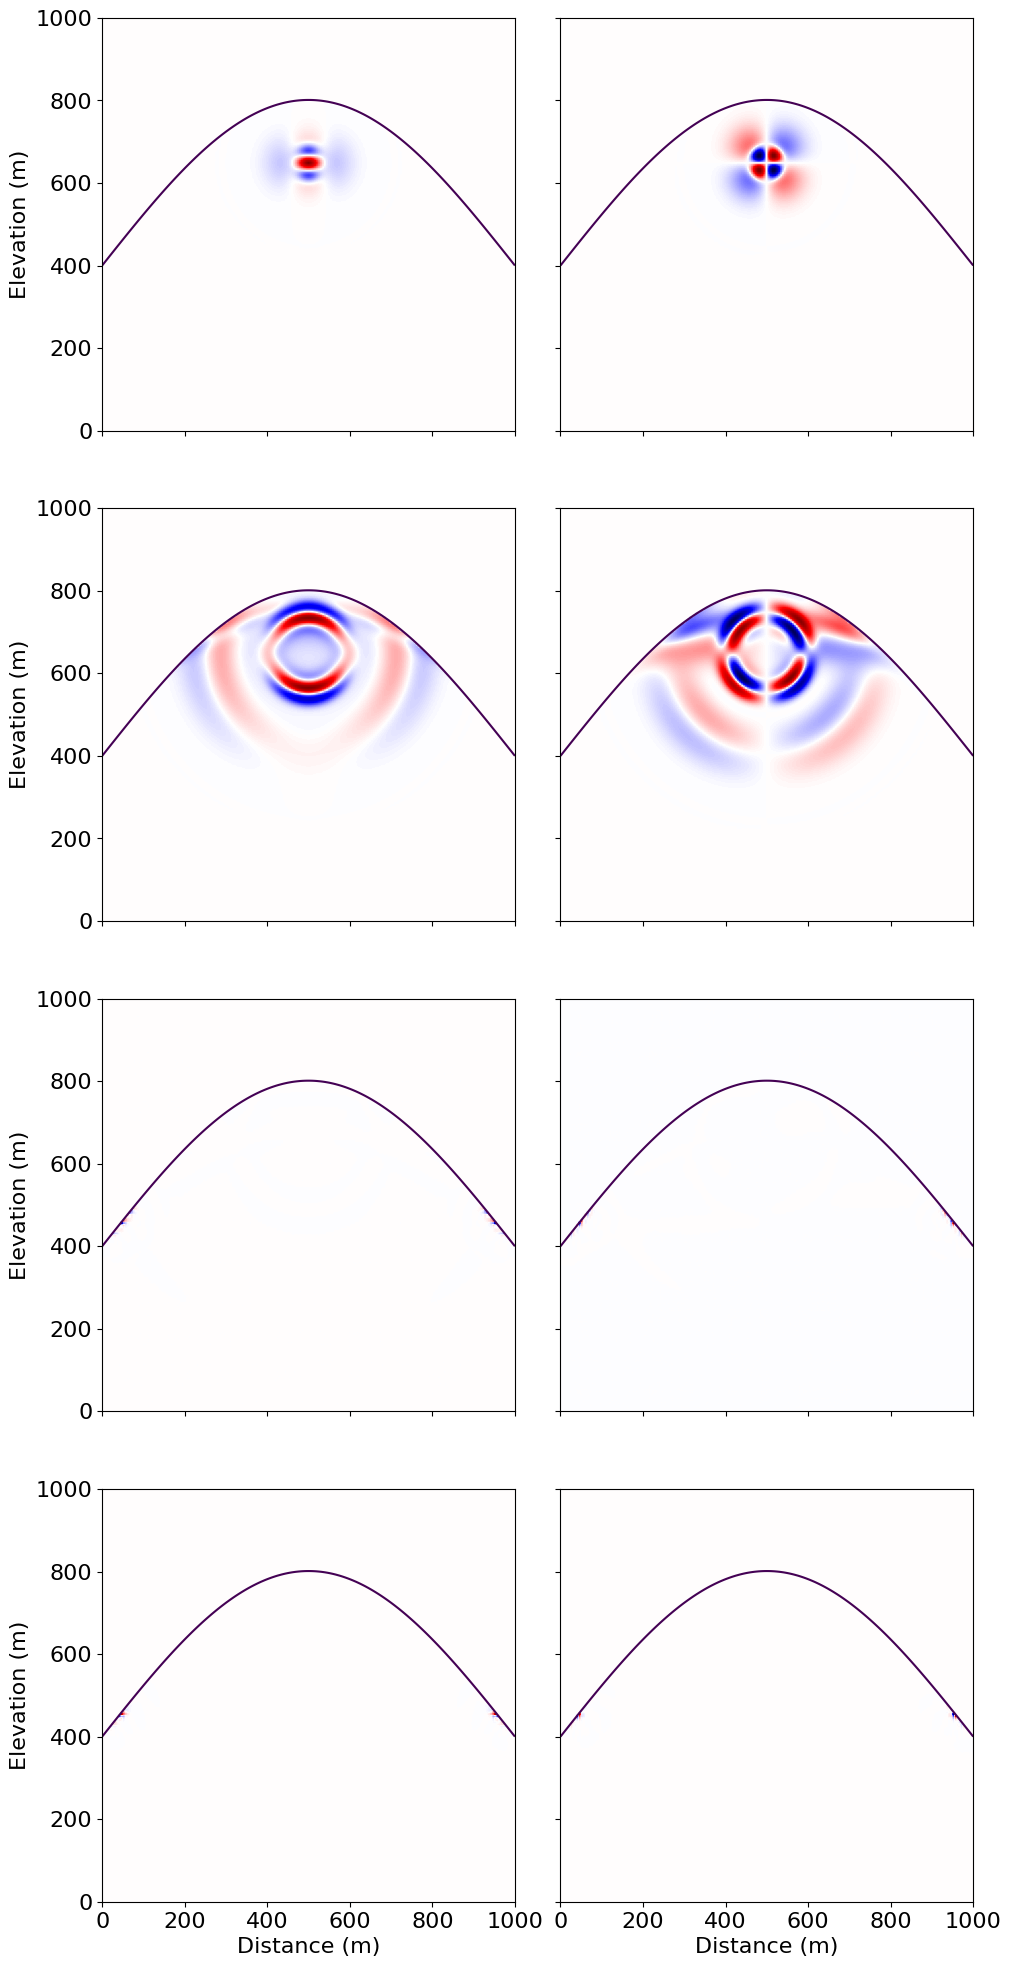

In [58]:
plot_snaps(uxsave_old, uysave_old, sdf, 'elastic_iso_unfiltered')

2.4771342
102.95355
26856680.0
inf


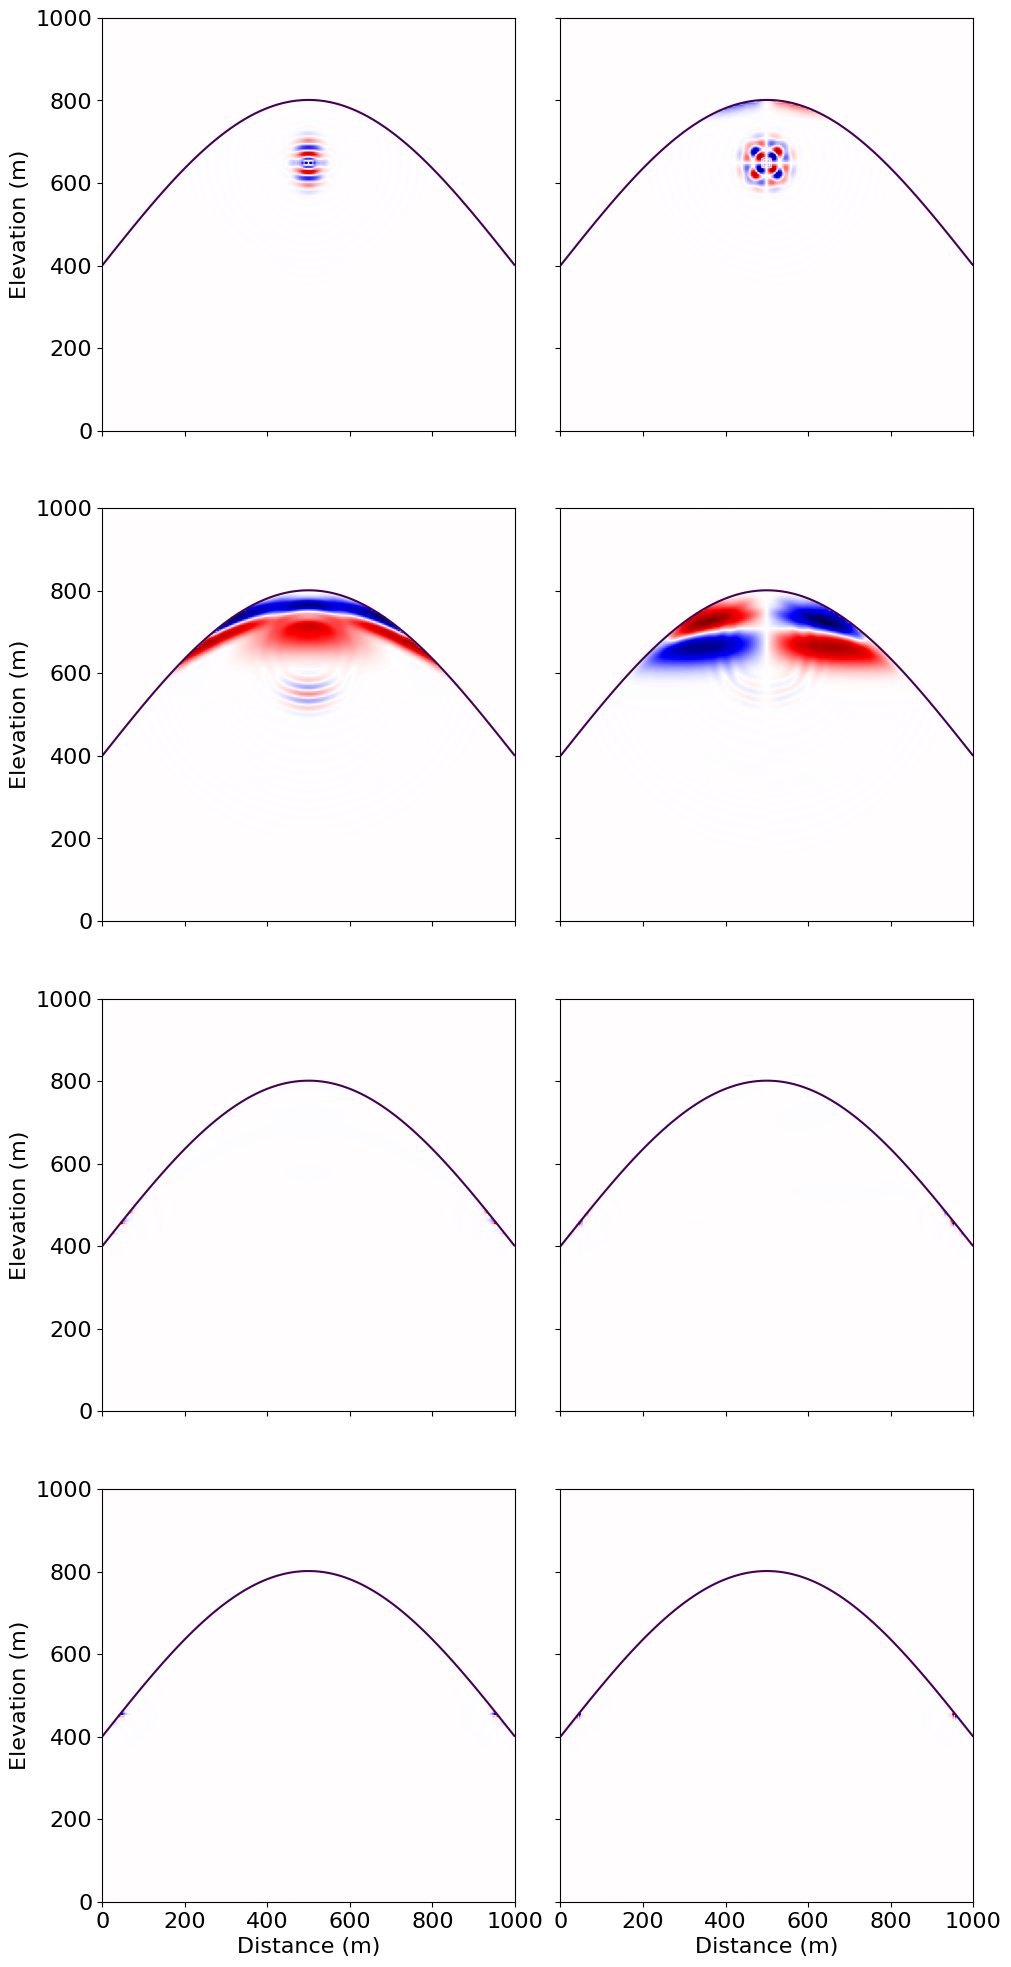

In [59]:
plot_snaps(uxsave.data - uxsave_old, uysave.data - uysave_old,
           sdf, 'elastic_iso_diff')